<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/Hp_optimization_without_stratified_K_Fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U keras-tuner

     |████████████████████████████████| 61kB 2.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73199 sha256=aaee0ccc5971ca50d237bc1abd073bf8b531846d2bccfe4b3f44c5b75b3ab20c
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15354 sha256=7a2b7fbf63604a71afe16ef1f01c62fc4a3ae4782209b9d0fcdae12875bc02ff
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [3]:
!rm -r my_dir

rm: cannot remove 'my_dir': No such file or directory


#Load data

In [4]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
train_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
test_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
train_labels = df_train.Histology

In [0]:
test_labels = df_test.Histology

##Z score dei dati

In [0]:
mean = train_data.mean(axis=0)
train_data_stand = train_data - mean
std = train_data.std(axis=0)
train_data_stand /= std

In [0]:
test_data_stand = test_data - mean
test_data_stand /= std

##Vettorizzare i label

In [0]:
word_index={'adenocarcinoma':0, 'large cell':1, 'squamous cell carcinoma':2}

In [0]:
train_labels_dec = [word_index[label] for label in train_labels]

In [0]:
test_labels_dec = [word_index[label] for label in test_labels]

In [19]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

#PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=0.85, svd_solver='full')

In [23]:
pca.fit(train_data_stand)

PCA(copy=True, iterated_power='auto', n_components=0.85, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [0]:
train_data_stand_pca = pca.transform(train_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)

In [25]:
train_data_stand_pca.shape

(131, 7)

#Building Network

In [0]:
from tensorflow import keras

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence

In [0]:
from tensorflow.keras import layers

In [0]:
from tensorflow.keras import regularizers

In [0]:
from tensorflow.keras.optimizers import SGD

In [0]:
from kerastuner.tuners import RandomSearch

In [0]:
def build_model(hp):
  model = keras.models.Sequential()

#  model.add(layers.Dense(units=(hp.Int('units', min_value=3, max_value=8, step=1)), 
#                         activation='relu', input_shape=(9,)))
 
#  drop_rate = hp.Choice('drop_rate', [0.0, 0.1, 0.2, 0.3,
#                              0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

  model.add(layers.Dense(4, activation='relu', input_shape=(7,)))
#  model.add(layers.Dropout(rate=drop_rate))
  model.add(layers.Dense(3, activation='softmax'))
#  sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
#  lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
  decay = hp.Choice('decay', [1e-4, 1e-5, 1e-6, 1e-7, 1e-8])
#  momentum = hp.Choice('momentum', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
  model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.5, decay=decay, nesterov=True), 
                loss='categorical_crossentropy', metrics=['accuracy'])
  return model

##Prova Train Test Split

In [0]:
from sklearn.model_selection import train_test_split


In [0]:
X_train, X_val, y_train, y_val = train_test_split(train_data_stand_pca, train_labels_dec,
                                                    stratify=train_labels_dec,
                                                    test_size=0.30,
                                                    random_state=3)


In [35]:
y_train.count(2)

38

#Keras tuner RandomSearch

In [36]:
num_epochs = 50
  
one_hot_partial_train_targets = to_categorical(y_train)
one_hot_val_targets = to_categorical(y_val)

tuner = RandomSearch(build_model, objective='val_acc', max_trials=8, 
                       executions_per_trial=5, directory='/content/my_dir', project_name='RandomSearch')
  
tuner.search_space_summary()

tuner.search(X_train, one_hot_partial_train_targets, validation_data=(X_val, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=5)
  


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 91 samples, validate on 40 samples
Epoch 1/50
91/91 [==============================] - 0s 3ms/sample - loss: 1.5808 - acc: 0.2747 - val_loss: 1.1216 - val_acc: 0.5000
Epoch 2/50
91/91 [==============================] - 0s 412us/sample - loss: 1.4522 - acc: 0.3187 - val_loss: 1.0941 - val_acc: 0.5000
Epoch 3/50
91/91 [==============================] - 0s 466us/sample - loss: 1.3524 - acc: 0.3846 - val_loss: 1.0797 - val_acc: 0.5250
Epoch 4/50
91/91 [==============================] - 0s 412us/sample - loss: 1.2812 - acc: 0.4176 - val_loss: 1.0744 - val_acc: 0.5250
Epoch 5/50
91/91 [==============================] - 0s 380us/sample - loss: 1.2187 - acc: 0.4505 - val_loss: 1.0735 - val_acc: 0.5000
Epoch 6/50
91/91 [==============================] - 0s 424us/sample - loss: 1.1696 - acc: 0.5055 - val_loss: 1.0742 - val_acc: 0.4750
Epoch 7/50
91/91 [==============================] - 0s 408us/sample - loss: 1.1324 - acc: 0.5165 - val_loss: 1.0740 - val_acc: 0.4750
Epoch 8/50
91/91 [==

Train on 91 samples, validate on 40 samples
Epoch 1/50
91/91 [==============================] - 0s 1ms/sample - loss: 2.1208 - acc: 0.2967 - val_loss: 2.2338 - val_acc: 0.2750
Epoch 2/50
91/91 [==============================] - 0s 486us/sample - loss: 1.8759 - acc: 0.2857 - val_loss: 1.9796 - val_acc: 0.3000
Epoch 3/50
91/91 [==============================] - 0s 437us/sample - loss: 1.6736 - acc: 0.2967 - val_loss: 1.8214 - val_acc: 0.2750
Epoch 4/50
91/91 [==============================] - 0s 374us/sample - loss: 1.5599 - acc: 0.2967 - val_loss: 1.7277 - val_acc: 0.2750
Epoch 5/50
91/91 [==============================] - 0s 354us/sample - loss: 1.4652 - acc: 0.2857 - val_loss: 1.6226 - val_acc: 0.2750
Epoch 6/50
91/91 [==============================] - 0s 385us/sample - loss: 1.3830 - acc: 0.3077 - val_loss: 1.5436 - val_acc: 0.2250
Epoch 7/50
91/91 [==============================] - 0s 518us/sample - loss: 1.3323 - acc: 0.2967 - val_loss: 1.4899 - val_acc: 0.2250
Epoch 8/50
91/91 [==

Train on 91 samples, validate on 40 samples
Epoch 1/50
91/91 [==============================] - 0s 1ms/sample - loss: 3.7167 - acc: 0.2637 - val_loss: 3.3503 - val_acc: 0.3000
Epoch 2/50
91/91 [==============================] - 0s 406us/sample - loss: 3.3417 - acc: 0.2637 - val_loss: 3.0803 - val_acc: 0.3000
Epoch 3/50
91/91 [==============================] - 0s 367us/sample - loss: 2.9961 - acc: 0.2527 - val_loss: 2.8734 - val_acc: 0.2750
Epoch 4/50
91/91 [==============================] - 0s 376us/sample - loss: 2.7302 - acc: 0.2527 - val_loss: 2.6982 - val_acc: 0.2750
Epoch 5/50
91/91 [==============================] - 0s 370us/sample - loss: 2.4934 - acc: 0.2527 - val_loss: 2.5083 - val_acc: 0.2750
Epoch 6/50
91/91 [==============================] - 0s 393us/sample - loss: 2.2784 - acc: 0.2857 - val_loss: 2.3577 - val_acc: 0.3000
Epoch 7/50
91/91 [==============================] - 0s 402us/sample - loss: 2.1084 - acc: 0.2747 - val_loss: 2.2401 - val_acc: 0.3000
Epoch 8/50
91/91 [==

Train on 91 samples, validate on 40 samples
Epoch 1/50
91/91 [==============================] - 0s 1ms/sample - loss: 1.5131 - acc: 0.2967 - val_loss: 1.3754 - val_acc: 0.3250
Epoch 2/50
91/91 [==============================] - 0s 398us/sample - loss: 1.3817 - acc: 0.2967 - val_loss: 1.3155 - val_acc: 0.3250
Epoch 3/50
91/91 [==============================] - 0s 351us/sample - loss: 1.2695 - acc: 0.3407 - val_loss: 1.2782 - val_acc: 0.3250
Epoch 4/50
91/91 [==============================] - 0s 410us/sample - loss: 1.1861 - acc: 0.3297 - val_loss: 1.2588 - val_acc: 0.3500
Epoch 5/50
91/91 [==============================] - 0s 386us/sample - loss: 1.1347 - acc: 0.3407 - val_loss: 1.2456 - val_acc: 0.3750
Epoch 6/50
91/91 [==============================] - 0s 430us/sample - loss: 1.1031 - acc: 0.3736 - val_loss: 1.2345 - val_acc: 0.4000
Epoch 7/50
91/91 [==============================] - 0s 417us/sample - loss: 1.0812 - acc: 0.3956 - val_loss: 1.2299 - val_acc: 0.3750
Epoch 8/50
91/91 [==

Train on 91 samples, validate on 40 samples
Epoch 1/50
91/91 [==============================] - 0s 1ms/sample - loss: 2.2055 - acc: 0.2747 - val_loss: 1.4071 - val_acc: 0.4000
Epoch 2/50
91/91 [==============================] - 0s 473us/sample - loss: 2.0013 - acc: 0.2637 - val_loss: 1.3466 - val_acc: 0.4250
Epoch 3/50
91/91 [==============================] - 0s 482us/sample - loss: 1.8284 - acc: 0.2527 - val_loss: 1.2930 - val_acc: 0.4500
Epoch 4/50
91/91 [==============================] - 0s 461us/sample - loss: 1.6903 - acc: 0.2747 - val_loss: 1.2513 - val_acc: 0.4250
Epoch 5/50
91/91 [==============================] - 0s 461us/sample - loss: 1.5698 - acc: 0.2747 - val_loss: 1.2241 - val_acc: 0.4000
Epoch 6/50
91/91 [==============================] - 0s 409us/sample - loss: 1.4854 - acc: 0.2967 - val_loss: 1.2036 - val_acc: 0.4250
Epoch 7/50
91/91 [==============================] - 0s 364us/sample - loss: 1.4161 - acc: 0.2967 - val_loss: 1.1842 - val_acc: 0.4500
Epoch 8/50
91/91 [==

INFO:tensorflow:Oracle triggered exit


In [37]:
tuner.search_space_summary()


In [38]:
tuner.results_summary()

In [0]:
random_params=tuner.get_best_hyperparameters()[0]

In [0]:
random_model = tuner.hypermodel.build(random_params)

In [41]:
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'decay': 1e-07}

In [0]:
best_model = tuner.get_best_models()[0]

In [43]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 15        
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________


##Train the best model RandomSearch

Per la valutazione del modello ottimizzato sul validation set uso la Stratified K-Fold

In [0]:
from sklearn.model_selection import StratifiedKFold

In [45]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_pca, train_labels_dec)

5

In [46]:
for train_index, test_index in skf.split(train_data_stand_pca, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  1   2   4   5   6   8  10  11  12  13  14  15  16  17  20  21  22  23
  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  46  47  48  49  50  52  55  58  59  60  61  62  63  64  65  67  68
  69  70  71  73  74  75  76  77  78  79  81  82  83  84  85  86  87  88
  89  91  92  93  94  96  97  98  99 100 101 102 103 104 106 107 108 110
 113 115 116 117 118 119 121 122 123 124 126 127 129 130] TEST: [  0   3   7   9  18  19  28  44  45  51  53  54  56  57  66  72  80  90
  95 105 109 111 112 114 120 125 128]
TRAIN: [  0   1   2   3   5   7   8   9  10  11  12  13  14  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  33  34  37  38  39  40  41  42
  44  45  46  47  48  49  51  53  54  55  56  57  58  61  62  63  64  66
  67  69  70  71  72  73  75  77  79  80  81  82  83  84  85  87  88  89
  90  92  94  95  96  97  98  99 100 101 103 105 106 107 109 110 111 112
 114 115 116 117 118 119 120 121 122 124 125 126 127 128 129] TEST: [  4   6  15 

In [47]:
#num_epochs = 50
all_acc_histories_RS = []
all_loss_histories_RS = []
all_val_acc_histories_RS = []
all_val_loss_histories_RS = []

for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  history_RS = best_model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=5)
  
  acc_history_RS = history_RS.history['acc']
  all_acc_histories_RS.append(acc_history_RS)

  loss_history_RS = history_RS.history['loss']
  all_loss_histories_RS.append(loss_history_RS)

  acc_val_history_RS = history_RS.history['val_acc']
  all_val_acc_histories_RS.append(acc_val_history_RS)

  loss_val_history_RS = history_RS.history['val_loss']
  all_val_loss_histories_RS.append(loss_val_history_RS)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 104 samples, validate on 27 samples
Epoch 1/50
104/104 [==============================] - 0s 947us/sample - loss: 0.9630 - acc: 0.5769 - val_loss: 1.3303 - val_acc: 0.4815
Epoch 2/50
104/104 [==============================] - 0s 405us/sample - loss: 0.9563 - acc: 0.5673 - val_loss: 1.3227 - val_acc: 0.4815
Epoch 3/50
104/104 [==============================] - 0s 371us/sample - loss: 0.9505 - acc: 0.5577 - val_loss: 1.3162 - val_acc: 0.4444
Epoch 4/50
104/104 [==============================] - 0s 346us/sample - loss: 0.9443 - acc: 0.5577 - val_loss: 1.3084 - val_acc: 0.4444
Epoch 5/50
104/104 [==============================] - 0s 304us/sample - loss: 0.9397 - acc: 0.5577 - val_loss: 1.3004 - val_acc: 0.4444
Epoch 6/50
104/104 [==============================] - 0s 320us/sample - loss: 0.9356 - acc: 0.5577 - val_loss: 1.2933 - val_acc: 0.4444
Epoch 7/50
104/104 [==============================] - 0s 333us/sample - loss: 0.9313 - acc: 0.5577 - val_loss: 1.2858 - val_acc: 0.4815
Epo

In [0]:
history_dict = history_RS.history

In [49]:
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

##Plotting training and validation loss RandomSearch


In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

In [0]:
average_acc_history_RS = [np.mean([x[i] for x in all_acc_histories_RS]) for i in range(num_epochs)]
average_loss_history_RS = [np.mean([x[i] for x in all_loss_histories_RS]) for i in range(num_epochs)]
average_val_acc_history_RS = [np.mean([x[i] for x in all_val_acc_histories_RS]) for i in range(num_epochs)]
average_val_loss_history_RS = [np.mean([x[i] for x in all_val_loss_histories_RS]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche

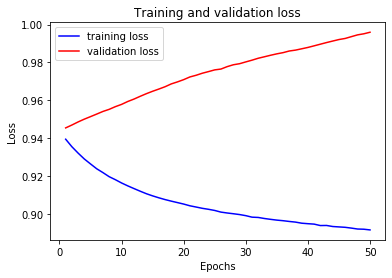

In [53]:
plt.plot(epochs, average_loss_history_RS, 'b', label='training loss')
plt.plot(epochs, average_val_loss_history_RS, 'r', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy RandomSearch

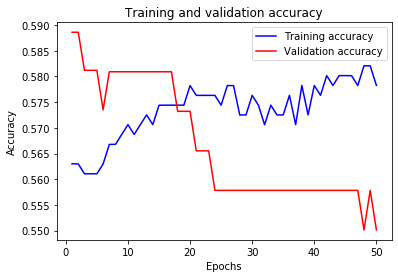

In [54]:
plt.plot(epochs, average_acc_history_RS, 'b', label='Training accuracy')
plt.plot(epochs, average_val_acc_history_RS, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 